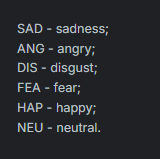

# Resourses
- https://www.kaggle.com/code/dmitrybabko/speech-emotion-recognition-conv1d
- https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition
- https://librosa.org/doc/latest/index.html
- https://www.kaggle.com/code/hossamemamo/speech-emotion-recognition-2-parallel-cnn-conv-2d
- https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition
- 

In [1]:
import os
import re

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
# from entropy import spectral_entropy
# from keras import layers
# from keras import models
# from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import itertools, torch, sys, random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# Paths to
Ravdess = "../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24"
Crema = "../input/speech-emotion-recognition-en/Crema"
Savee = "../input/speech-emotion-recognition-en/Savee"
Tess = "../input/speech-emotion-recognition-en/Tess"
print(os.listdir(Ravdess))

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [3]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

,Emotion,Path
0,disgust,../input/speech-emotion-recognition-en/Crema/1...
1,happy,../input/speech-emotion-recognition-en/Crema/1...
2,happy,../input/speech-emotion-recognition-en/Crema/1...
3,disgust,../input/speech-emotion-recognition-en/Crema/1...
4,disgust,../input/speech-emotion-recognition-en/Crema/1...


In [4]:
# df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
df = pd.concat([Crema_df], axis=0)
df.shape

(7442, 2)

In [5]:
%matplotlib inline

plt.style.use("ggplot")

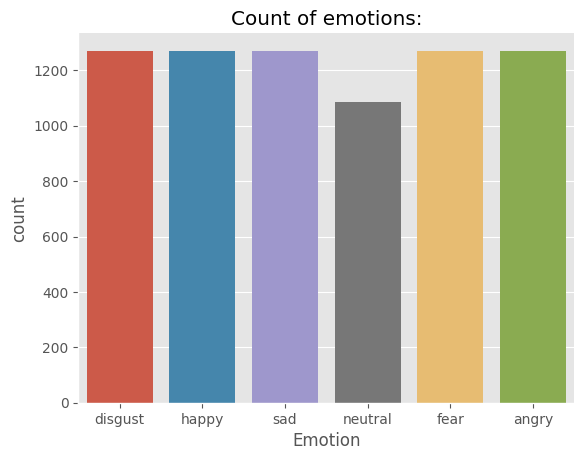

In [6]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [7]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

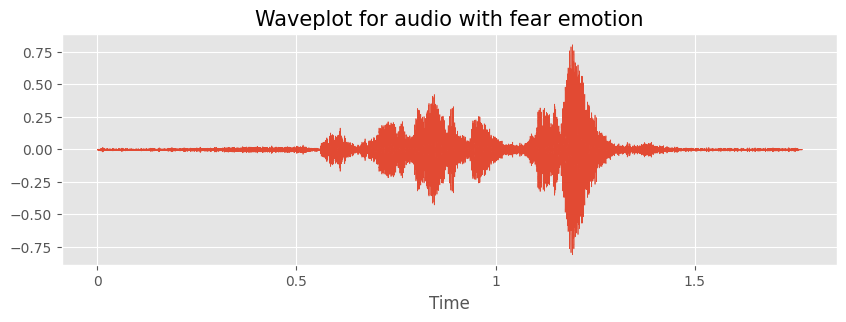

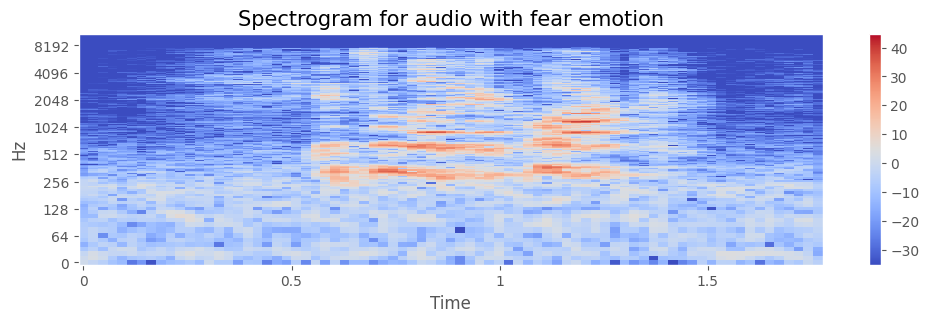

In [8]:
emotion='fear'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

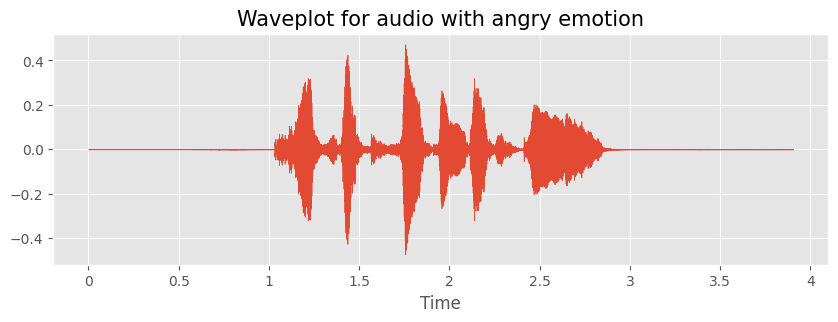

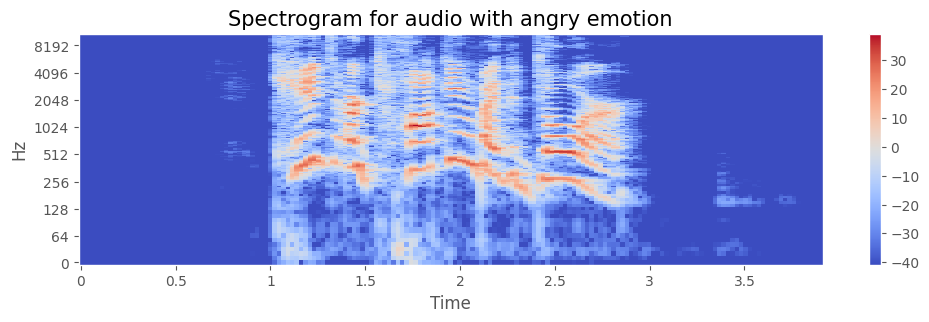

In [14]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

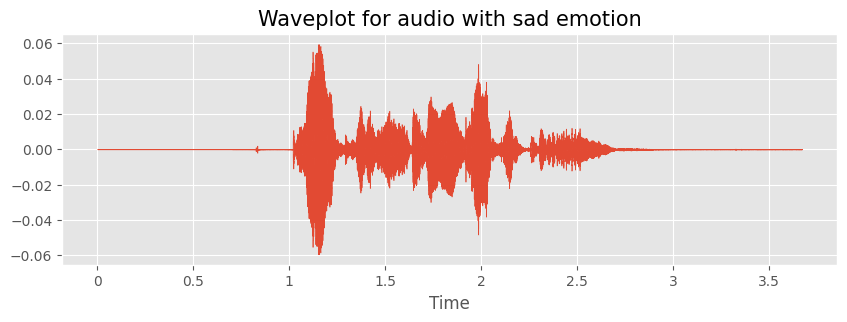

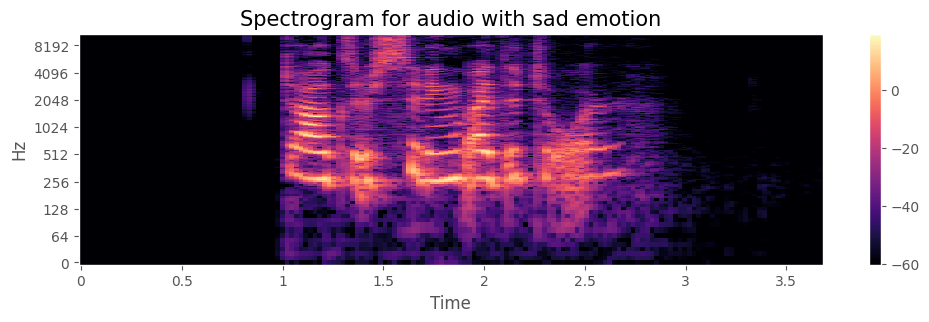

In [15]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data augmentation

We have some ways for data augmentation in sound data:

1. Noise injection
2. Stretching
3. Shifting
4. Pitching

In [9]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [10]:
df.head()

,Emotion,Path
0,disgust,../input/speech-emotion-recognition-en/Crema/1...
1,happy,../input/speech-emotion-recognition-en/Crema/1...
2,happy,../input/speech-emotion-recognition-en/Crema/1...
3,disgust,../input/speech-emotion-recognition-en/Crema/1...
4,disgust,../input/speech-emotion-recognition-en/Crema/1...


## 2D

In [11]:
n_fft = 2048
hop_length = 512

In [12]:
!pip install torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [14]:
import torchaudio
import torchaudio.transforms as transforms
from tqdm import tqdm

S_dB_Total = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for idx, path in tqdm(enumerate(df.Path)):
    waveform, sample_rate = torchaudio.load(path)

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    
    # Convert to tensor
    waveform = torch.tensor(waveform).to(device)

    # Convert to mel spectrogram
    mel_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ).to(device)
    
    S = mel_transform(waveform)

    # Convert to dB
    power_to_db = transforms.AmplitudeToDB()
    S_dB = power_to_db(S)

    S_dB_Total.append(S_dB.squeeze())

7442it [02:21, 52.74it/s]


In [15]:
sizes=[]
for x in S_dB_Total:
    sizes.append(x.shape[1])

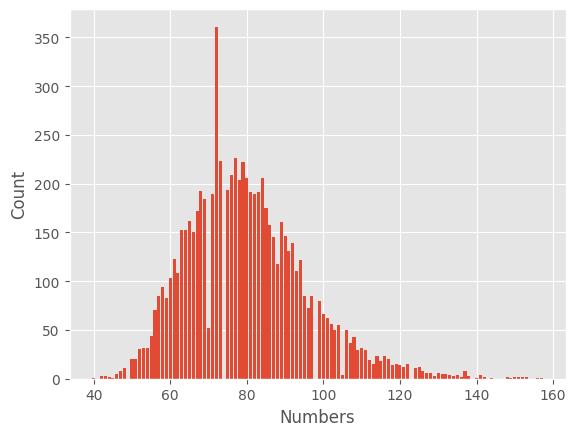

min is 40
max is 157


In [16]:
# Calculate the bin counts
bincount_array = np.histogram(sizes, bins=np.arange(min(sizes), max(sizes)+2))[0]

# Create a list of labels for the x-axis
x_labels = np.arange(min(sizes), max(sizes)+1)

# Plot the bin counts as a bar plot
plt.bar(x_labels, bincount_array)

# Set labels and title
plt.xlabel('Numbers')
plt.ylabel('Count')
plt.show()

print(f'min is {min(sizes)}')
print(f'max is {max(sizes)}')

In [17]:
import numpy as np
padding_length = 160
padded_list = []
for array in S_dB_Total:
    current_shape = array.cpu().shape
    padding = [(0, 0), (0, padding_length - current_shape[1])]
    padded_array = np.pad(array.cpu(), padding, mode='constant', constant_values=0)
    padded_list.append(padded_array)

# Convert the padded list to a NumPy array
data_2D = np.array(padded_list)
    

In [18]:
data_2D.shape

(7442, 128, 160)

In [19]:
df.Emotion.head()

0    disgust
1      happy
2      happy
3    disgust
4    disgust
Name: Emotion, dtype: object

In [20]:
#normalization
from sklearn.preprocessing import MinMaxScaler

# Reshape the array to 2D
reshaped_data = data_2D.reshape((-1, 1))

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
normalized_data = normalized_data.reshape(data_2D.shape)

In [21]:
normalized_data[1]

array([[0.62733775, 0.640122  , 0.6647765 , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.5898795 , 0.59867305, 0.6470086 , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.5187135 , 0.5942637 , 0.6223626 , ..., 0.64415836, 0.64415836,
        0.64415836],
       ...,
       [0.48149693, 0.4833352 , 0.47374046, ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.4888742 , 0.48686188, 0.4803564 , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.48625338, 0.4829375 , 0.48455703, ..., 0.64415836, 0.64415836,
        0.64415836]], dtype=float32)

In [22]:
data=np.expand_dims(normalized_data, axis=1)

In [23]:
labels=df.Emotion.replace({'neutral': 1, 'happy': 3, 'sad': 4, 'angry': 5, 'fear': 6, 'disgust': 7, 'surprise': 8}).to_numpy()

In [24]:
labels.shape

(7442,)

In [25]:
data.shape

(7442, 1, 128, 160)

In [26]:
# torch.save({
#     'data': torch.tensor(data_2D),  
#     'labels': torch.tensor(labels) 
# }, 'dataset.pt')


## Final Size

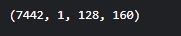
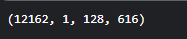

## Data Split

In [27]:
#train test split
from sklearn.model_selection import train_test_split
# Perform the train-test split (70% train & validation, 30% test )
X_trainAndVal, X_test, y_trainAndVal, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

# Perform the train-validation split (5% test, 95% train)
X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size=0.05, stratify=y_trainAndVal, random_state=42)

# Print the sizes of each split
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 4948
Validation set size: 261
Test set size: 2233


In [28]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self,audio,label):
        self.audios=audio
        self.labels=label

    def __len__(self):
        return len(self.audios)

    def get_batch_imgs(self, idx):
        # Fetch a batch of inputs
        return self.audios[idx]
    
    def get_batch_labels(self, idx):
    # Fetch a batch of inputs
        return self.labels[idx]

    
    def __getitem__(self, index):
        audios=self.get_batch_imgs(index)
        labels=self.get_batch_labels(index)
        return audios,labels

In [29]:
train_dataset = AudioDataset(X_train,y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# Create a DataLoader from the dataset

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model